In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
data_dir = "/content/drive/MyDrive/Dataset/data"
classes = ["COVID", "NORMAL", "PNEUMONIA"]
train_dir = "/content/drive/MyDrive/Dataset/Train"
test_dir = "/content/drive/MyDrive/Dataset/Test"
val_dir = "/content/drive/MyDrive/Dataset/Valid"

# Create directories for train, test, and validation data
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Split data into train, test, and validation sets
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)
    train_files, test_val_files = train_test_split(image_files, test_size=0.2, random_state=42)
    test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

    # Copy images to appropriate directories
    for filename in train_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(train_dir, class_name, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for filename in test_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(test_dir, class_name, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for filename in val_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(val_dir, class_name, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

print("Data splitting and copying completed.")


Data splitting and copying completed.


In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define paths
data_dir = "/content/drive/MyDrive/Dataset"
train_dir = os.path.join(data_dir, "Train")
val_dir = os.path.join(data_dir, "Valid")
test_dir = os.path.join(data_dir, "Test")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Define transformations including data augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),         # Randomly rotate the image up to 30 degrees
    transforms.RandomHorizontalFlip(p=0.5),       # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomResizedCrop(224),            # Randomly crop a square patch of size 224
    transforms.ColorJitter(brightness=0.2,        # Randomly adjust brightness, contrast, saturation, and hue
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.2),
    transforms.ToTensor(),                        # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Define batch size for DataLoader
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Check the size of datasets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))


Training dataset size: 4038
Validation dataset size: 507
Test dataset size: 505


In [6]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# Freeze all the parameters in the pre-trained model
for param in resnet.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the number of classes in your dataset
num_classes = 3  # COVID, NORMAL, PNEUMONIA
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)

# Define the loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Print the architecture of the modified ResNet model
print(resnet)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the number of epochs
num_epochs = 5

# Define early stopping parameters
patience = 3
early_stopping_counter = 0
best_val_loss = float('inf')

# Train the model
for epoch in range(num_epochs):
    # Set the model to train mode
    resnet.train()

    # Initialize variables for monitoring training
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterate over the training dataset
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Compute training statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Compute training loss and accuracy
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_predictions / total_predictions

    # Set the model to evaluation mode
    resnet.eval()

    # Initialize variables for monitoring validation
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    # Iterate over the validation dataset
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)

            # Compute validation statistics
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total_predictions += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()

    # Compute validation loss and accuracy
    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_correct_predictions / val_total_predictions

    # Print training and validation statistics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Check for early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training completed.")


Epoch 1/5: 100%|██████████| 127/127 [00:45<00:00,  2.78it/s]


Epoch 1/5, Train Loss: 0.4442, Train Acc: 0.8494, Val Loss: 0.2717, Val Acc: 0.9112


Epoch 2/5: 100%|██████████| 127/127 [00:36<00:00,  3.47it/s]


Epoch 2/5, Train Loss: 0.2318, Train Acc: 0.9339, Val Loss: 0.2301, Val Acc: 0.9172


Epoch 3/5: 100%|██████████| 127/127 [00:35<00:00,  3.54it/s]


Epoch 3/5, Train Loss: 0.2061, Train Acc: 0.9321, Val Loss: 0.2090, Val Acc: 0.9250


Epoch 4/5: 100%|██████████| 127/127 [00:35<00:00,  3.58it/s]


Epoch 4/5, Train Loss: 0.1918, Train Acc: 0.9378, Val Loss: 0.2076, Val Acc: 0.9250


Epoch 5/5: 100%|██████████| 127/127 [00:34<00:00,  3.69it/s]


Epoch 5/5, Train Loss: 0.1704, Train Acc: 0.9430, Val Loss: 0.1888, Val Acc: 0.9428
Training completed.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define hyperparameters to tune
learning_rates = [0.001, 0.0001]  # Learning rates to experiment with
batch_sizes = [16, 32, 64]         # Batch sizes to experiment with

# Define the number of epochs
num_epochs = 5

# Initialize dictionary to store results
results = {}

# Perform hyperparameter tuning
for lr in learning_rates:
    for batch_size in batch_sizes:
        # Load pre-trained ResNet model
        resnet = models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        num_classes = 3
        num_features = resnet.fc.in_features
        resnet.fc = nn.Linear(num_features, num_classes)
        resnet.to(device)

        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(resnet.parameters(), lr=lr)

        # Create DataLoaders with the specified batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Train the model
        for epoch in range(num_epochs):
            # Training phase
            resnet.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = resnet(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # Validation phase
            resnet.eval()
            val_loss = 0.0
            val_correct_predictions = 0
            val_total_predictions = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = resnet(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total_predictions += labels.size(0)
                    val_correct_predictions += (predicted == labels).sum().item()

            # Compute validation loss and accuracy
            val_epoch_loss = val_loss / len(val_dataset)
            val_epoch_acc = val_correct_predictions / val_total_predictions

            # Store results
            results[(lr, batch_size)] = (val_epoch_loss, val_epoch_acc)

            # Print progress
            print(f"LR: {lr}, Batch Size: {batch_size}, Epoch: {epoch + 1}/{num_epochs}, "
                  f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

# Print results
print("Hyperparameter tuning results:")
for (lr, batch_size), (val_loss, val_acc) in results.items():
    print(f"LR: {lr}, Batch Size: {batch_size}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


LR: 0.001, Batch Size: 16, Epoch: 1/5, Val Loss: 0.2699, Val Acc: 0.9034
LR: 0.001, Batch Size: 16, Epoch: 2/5, Val Loss: 0.2418, Val Acc: 0.9132
LR: 0.001, Batch Size: 16, Epoch: 3/5, Val Loss: 0.2055, Val Acc: 0.9329
LR: 0.001, Batch Size: 16, Epoch: 4/5, Val Loss: 0.2288, Val Acc: 0.9211
LR: 0.001, Batch Size: 16, Epoch: 5/5, Val Loss: 0.1930, Val Acc: 0.9448
LR: 0.001, Batch Size: 32, Epoch: 1/5, Val Loss: 0.2803, Val Acc: 0.9112
LR: 0.001, Batch Size: 32, Epoch: 2/5, Val Loss: 0.2390, Val Acc: 0.9172
LR: 0.001, Batch Size: 32, Epoch: 3/5, Val Loss: 0.2073, Val Acc: 0.9290
LR: 0.001, Batch Size: 32, Epoch: 4/5, Val Loss: 0.2043, Val Acc: 0.9389
LR: 0.001, Batch Size: 32, Epoch: 5/5, Val Loss: 0.2564, Val Acc: 0.9053
LR: 0.001, Batch Size: 64, Epoch: 1/5, Val Loss: 0.3163, Val Acc: 0.9014
LR: 0.001, Batch Size: 64, Epoch: 2/5, Val Loss: 0.2439, Val Acc: 0.9112
LR: 0.001, Batch Size: 64, Epoch: 3/5, Val Loss: 0.2146, Val Acc: 0.9250
LR: 0.001, Batch Size: 64, Epoch: 4/5, Val Loss: 0.

Classification Report:
              precision    recall  f1-score   support

       COVID       0.95      0.97      0.96       163
      NORMAL       0.90      0.90      0.90       181
   PNEUMONIA       0.88      0.85      0.87       163

    accuracy                           0.91       507
   macro avg       0.91      0.91      0.91       507
weighted avg       0.91      0.91      0.91       507

Overall Accuracy: 0.9073
Micro-Averaged Precision: 0.9073
Macro-Averaged Precision: 0.9072
Micro-Averaged Recall: 0.9073
Macro-Averaged Recall: 0.9075
Micro-Averaged F1-score: 0.9073
Macro-Averaged F1-score: 0.9072


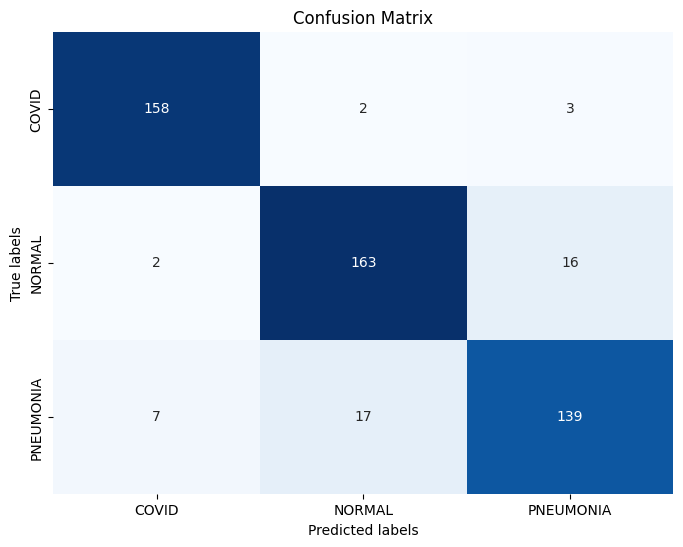

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Compute classification report
print("Classification Report:")
print(classification_report(val_targets, val_predictions, target_names=classes))

# Compute overall metrics
accuracy = accuracy_score(val_targets, val_predictions)
precision_micro = precision_score(val_targets, val_predictions, average='micro')
precision_macro = precision_score(val_targets, val_predictions, average='macro')
recall_micro = recall_score(val_targets, val_predictions, average='micro')
recall_macro = recall_score(val_targets, val_predictions, average='macro')
f1_micro = f1_score(val_targets, val_predictions, average='micro')
f1_macro = f1_score(val_targets, val_predictions, average='macro')

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Micro-Averaged Precision: {precision_micro:.4f}")
print(f"Macro-Averaged Precision: {precision_macro:.4f}")
print(f"Micro-Averaged Recall: {recall_micro:.4f}")
print(f"Macro-Averaged Recall: {recall_macro:.4f}")
print(f"Micro-Averaged F1-score: {f1_micro:.4f}")
print(f"Macro-Averaged F1-score: {f1_macro:.4f}")

# Plot confusion matrix
cm = confusion_matrix(val_targets, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()



Test Metrics:
Accuracy: 0.9050
Precision: 0.9068
Recall: 0.9050
F1-score: 0.9056


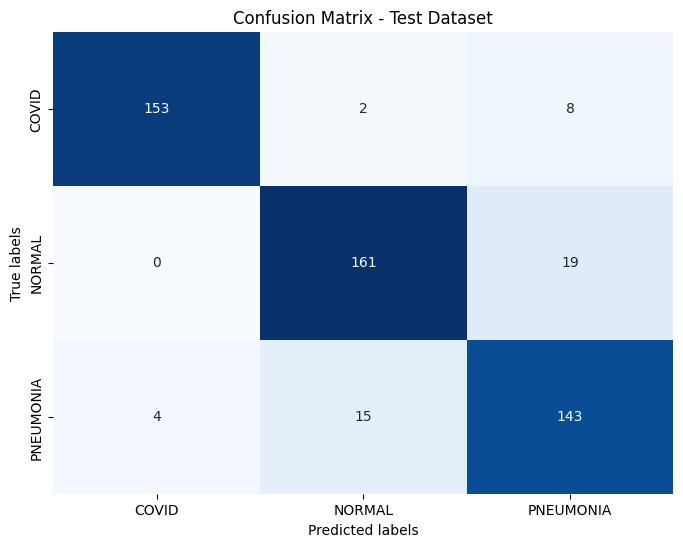

In [18]:
# Evaluate the model on the test dataset
test_predictions = []
test_targets = []

resnet.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1-score on the test dataset
test_accuracy = accuracy_score(test_targets, test_predictions)
test_precision = precision_score(test_targets, test_predictions, average='weighted')
test_recall = recall_score(test_targets, test_predictions, average='weighted')
test_f1 = f1_score(test_targets, test_predictions, average='weighted')

print("Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")

# Plot confusion matrix for the test dataset
test_cm = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Test Dataset")
plt.show()


In [19]:
print("done by Gourav Singh (1209784)")

done by Gourav Singh (1209784)
